# Can we use perplexity as a metric to detect AI generated text?
# With language detection

### Why this notebook?
With the rise of Generative AI in education, there is a growing need for teachers to check whether a text is written by a human or an AI. A possible metric to detect AI generated text is perplexity. In this notebook we will compare 5 AI generated texts with 5 human generated texts, calculate their perplexity and compare results.

### TL;DR
Yes, this works. (For the small set of given texts that is.)

### Contents
0. Install packages
1. Settings
2. Getting perplexity for 10 openAI generated texts
3. Getting the perplexity for 10 human written texts
4. Comparing results and conclusion

### Sources
The English human written text is from two articles:
- https://www.economist.com/europe/2023/06/09/ukraines-assault-in-zaporizhia-may-be-the-focus-of-its-offensive
- https://www.bbc.com/news/world-latin-america-65864158

The Dutch human written text is from these two sources:
- https://www.nu.nl/binnenland/6267525/hitteprotocol-rijkswaterstaat-geldt-ook-maandag-behalve-in-het-noorden.html
- https://nos.nl/artikel/2478434-het-oekraiense-tegenoffensief-is-begonnen-hoe-staat-het-ervoor

The AI generated text is from OpenAI GPT-3.5 using their API.

## Calculating perplexity

Perplexity is a metric that is used to measure the quality of language models. It is reversely related to the entropy of a model. 


- blog: https://medium.com/@priyankads/perplexity-of-language-models-41160427ed72
- wiki: https://en.wikipedia.org/wiki/Perplexity
- o'reilly: https://www.oreilly.com/library/view/natural-language-processing/9781787285101/ch21s05.html (to do)

## 0. Install packages

In [132]:
#pip install openai
#pip install transformers
#pip install torch

## 1. Settings

In [18]:
#set API keys
import os
import config
os.environ['OPENAI_API_KEY'] = config.openai_key # replace with your own API-key, but don't keep it in your source code :-)

In [19]:
#OpenAI settings
import openai  # for calling the OpenAI API

# models
EMBEDDING_MODEL = "text-embedding-ada-002" #choose your embeddings model
GPT_MODEL = "gpt-3.5-turbo" #choose the generative model

In [20]:
#Huggingface Transformers settings (to do perplexity)
from transformers import AutoModelForCausalLM, AutoTokenizer
model = AutoModelForCausalLM.from_pretrained("gpt2")
tokenizer = AutoTokenizer.from_pretrained("gpt2")

## 2. Getting perplexity for 10 openAI generated texts

In [21]:
query_list = []
with open ('prompts_nl.txt', mode='r') as prompts: #change to 'prompts_nl.txt' for Dutch prompts
    for prompt in prompts: #for each row do the following
        #query = prompt.split()
        query_list.append(prompt)
query_list

['Wat is een perceptron en wat is een multi layered perceptron?\n',
 'Wat is het verschil tussen machine leren en diep leren?\n',
 'Let het backpropagatie algoritme uit.\n',
 'Wie was Geoff Hinton en wat was zijn rol in de ontwikkeling van neurale netwerken?\n',
 'Hoe kunnen we onderscheid maken tussen een door een KI gegenereerde tekst en een door een mens geschreven tekst?\n',
 'Beschrijf het verschil tussen menselijke neuronen en kunstmatige neuronen\n',
 'Op welke manier zal generatieve KI de wereld gaan veranderen?\n',
 'Wat was er zo belangrijk aan het taalmodel BERT in het vak NLP.\n',
 "Leg uit waarom Meta's LLaMA beter is dan GPT3.5\n",
 'Wat zijn Gaussian Mixtures?']

In [23]:
oa_result_list =[] 
for i in range(len(query_list)):
    query = query_list[i]
 
    response = openai.ChatCompletion.create(
        messages=[
            {'role': 'system', 'content': ''},
            {'role': 'user', 'content': query},
        ],
        model=GPT_MODEL,
        temperature=0
        
        , #temperature is a parameter about the entropy of the model (the higher, the greater variation in results)
        )
        
    #print(response['choices'][0]['message']['content'])
    openai_result = response['choices'][0]['message']['content']
    oa_result_list.append(openai_result)

In [24]:
print(len(oa_result_list))
for i in range(len(oa_result_list)):
    print(oa_result_list[i])
    print(100*'-')

10
Een perceptron is een eenvoudig neuraal netwerk dat bestaat uit één enkele laag van neuronen. Het is een lineair classificatiemodel dat kan worden gebruikt om gegevens te classificeren in twee categorieën. Het perceptron ontvangt invoergegevens en past gewichten toe op de invoer om een lineaire combinatie te berekenen. Deze lineaire combinatie wordt vervolgens door een activatiefunctie geleid om een uitvoer te produceren.

Een multi-layer perceptron (MLP) is een neuraal netwerk dat bestaat uit meerdere lagen van neuronen. Het is een niet-lineair classificatiemodel dat kan worden gebruikt om gegevens te classificeren in meerdere categorieën. In tegenstelling tot het perceptron, kan een MLP complexe patronen in de gegevens leren door middel van de toepassing van niet-lineaire activatiefuncties op de lineaire combinaties van de invoergegevens. Het MLP kan worden getraind met behulp van backpropagation, een algoritme dat de gewichten van het netwerk aanpast om de nauwkeurigheid van de c

In [25]:
#detect the language 
import deepl 
import config #this is my own config file. You'll need to create your own. See notebook 2.x
my_api_key = config.deepl #get your own API Key!
translator = deepl.Translator(my_api_key) 

language_list=[]
for i in range(len(oa_result_list)):
    text = oa_result_list[i]
    result = translator.translate_text(text, target_lang="EN-US")
    #print(result.detected_source_lang)
    language_list.append(result.detected_source_lang)
language_list

['NL', 'NL', 'NL', 'NL', 'NL', 'NL', 'NL', 'NL', 'NL', 'NL']

In [26]:
#combining language with AI
lang_ai_list=[]
for i in range(len(language_list)):
    new_str = language_list[i]+"_AI"
    lang_ai_list.append(new_str)
lang_ai_list

['NL_AI',
 'NL_AI',
 'NL_AI',
 'NL_AI',
 'NL_AI',
 'NL_AI',
 'NL_AI',
 'NL_AI',
 'NL_AI',
 'NL_AI']

In [27]:
#getting the perplexity tensor for the openai generated text
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
perplexity_list =[]
for i in range(len(oa_result_list)):
    inputs_text = tokenizer(oa_result_list[i], return_tensors = "pt")
    loss = model(input_ids = inputs_text["input_ids"], labels = inputs_text["input_ids"]).loss
    ppl = torch.exp(loss)
    print(ppl)
    perplexity_list.append(ppl)

tensor(67.5429, grad_fn=<ExpBackward0>)
tensor(58.1080, grad_fn=<ExpBackward0>)
tensor(48.4369, grad_fn=<ExpBackward0>)
tensor(69.6907, grad_fn=<ExpBackward0>)
tensor(44.2813, grad_fn=<ExpBackward0>)
tensor(69.5256, grad_fn=<ExpBackward0>)
tensor(46.7678, grad_fn=<ExpBackward0>)
tensor(99.2462, grad_fn=<ExpBackward0>)
tensor(32.8285, grad_fn=<ExpBackward0>)
tensor(82.5210, grad_fn=<ExpBackward0>)


In [28]:
#converting tensors to string and getting just the values
ai_text_perplexity= []
for i in range(len(perplexity_list)):
    tensor_string=str(perplexity_list[i])
    a,b = tensor_string.split(",")
    tensor, perplexity = a.split("(")
    ai_text_perplexity.append(float(perplexity))
print(ai_text_perplexity)

[67.5429, 58.108, 48.4369, 69.6907, 44.2813, 69.5256, 46.7678, 99.2462, 32.8285, 82.521]


In [29]:
#combining two lists to one dictionary using 'zip'
ai_perplexity_dict = {key: value for key, value in zip(ai_text_perplexity, lang_ai_list)}
ai_perplexity_dict

{67.5429: 'NL_AI',
 58.108: 'NL_AI',
 48.4369: 'NL_AI',
 69.6907: 'NL_AI',
 44.2813: 'NL_AI',
 69.5256: 'NL_AI',
 46.7678: 'NL_AI',
 99.2462: 'NL_AI',
 32.8285: 'NL_AI',
 82.521: 'NL_AI'}

## 3. Getting the perplexity for 10 human written texts

In [7]:
query_list = []
with open ('humanwritten_nl.txt', mode='r') as prompts: #change to 'humanwritten_nl.txt' if you prefer Dutch
    for prompt in prompts: #for each row do the following
        #query = prompt.split()
        query_list.append(prompt)
query_list

['Het hitteprotocol van Rijkswaterstaat geldt ook maandag. Dat houdt in dat weggebruikers die met pech langs de weg staan, direct worden geholpen. Vandaag is het protocol in heel Nederland van kracht, maandag in alle provincies behalve Friesland, Groningen en Drenthe.\n',
 'Het hitteprotocol geldt maandag van 10.00 tot 22.00 uur. Ook zaterdag was het in de meeste provincies van kracht wegens de tropische temperaturen. Zodra er een grote kans is dat het 30 graden of warmer wordt, zet Rijkswaterstaat het protocol in. Rijkswaterstaat wil niet dat gestrande weggebruikers bij hoge temperaturen langdurig in de zon moeten wachten.\n',
 'Daarom is het de bedoeling dat mensen bij autopech zo snel mogelijk door een berger naar een plek met voorzieningen worden gebracht, zoals een tankstation. Weggebruikers krijgen het advies goed voorbereid op weg te gaan en alert te zijn bij hitte. Zo adviseert Rijkswaterstaat genoeg drinkwater en een paraplu tegen de zon in de auto te leggen.\n',
 'Hoe effecti

In [32]:
#detect the language 
import deepl
import config #this is my own config file. You'll need to create your own. See notebook 2.x
my_api_key = config.deepl #get your own API Key!
translator = deepl.Translator(my_api_key) 

def get_hw_language_list(query_list):
    hw_language_list = []
    for i in range(len(query_list)):
        text = query_list[i]
        result = translator.translate_text(text, target_lang="EN-US")
        #print(result.detected_source_lang)
        hw_language_list.append(result.detected_source_lang)
    return hw_language_list
get_hw_language_list(query_list)

['NL', 'NL', 'NL', 'NL', 'NL', 'NL', 'NL', 'NL', 'NL', 'NL']

In [33]:
#combining language with AI
def get_lang_of_human_list(hw_language_list):
    lang_human_list=[]
    for i in range(len(hw_language_list)):
        new_str = hw_language_list[i]+"_human"
        lang_human_list.append(new_str)
    return lang_human_list
get_lang_of_human_list(hw_language_list)

['NL_human',
 'NL_human',
 'NL_human',
 'NL_human',
 'NL_human',
 'NL_human',
 'NL_human',
 'NL_human',
 'NL_human',
 'NL_human']

In [38]:
import torch

def get_human_text_perplexity(query_list, tokenizer, model):
    human_text_perplexity= []
    for i in range(len(query_list)):
        inputs_text = tokenizer(query_list[i], return_tensors="pt")
        loss = model(input_ids=inputs_text["input_ids"], labels=inputs_text["input_ids"]).loss
        ppl = torch.exp(loss)
        tensor_string=str(pp_list_human[i])
        a,b = tensor_string.split(",")
        tensor, perplexity = a.split("(")
        human_text_perplexity.append(float(perplexity))
    return human_text_perplexity
get_human_text_perplexity(query_list, tokenizer, model)

[211.6711,
 222.4663,
 304.6771,
 326.6619,
 327.4499,
 305.0379,
 141.3531,
 360.3304,
 153.0569,
 207.1511]

In [39]:
#combining two lists to one dictionary using 'zip'
ai_perplexity_dict = {key: value for key, value in zip(human_text_perplexity, lang_human_list)}
ai_perplexity_dict

{211.6711: 'NL_human',
 222.4663: 'NL_human',
 304.6771: 'NL_human',
 326.6619: 'NL_human',
 327.4499: 'NL_human',
 305.0379: 'NL_human',
 141.3531: 'NL_human',
 360.3304: 'NL_human',
 153.0569: 'NL_human',
 207.1511: 'NL_human'}

## 4. Comparing results and conclusion

In [67]:
#create one list
results =ai_text_perplexity+human_text_perplexity
print(results)
print(len(results))

[67.5429, 58.108, 48.4369, 69.6907, 44.2813, 69.5256, 46.7678, 99.2462, 32.8285, 82.521, 211.6711, 222.4663, 304.6771, 326.6619, 327.4499, 305.0379, 141.3531, 360.3304, 153.0569, 207.1511]
20


ValueError: 'c' argument has 21 elements, which is inconsistent with 'x' and 'y' with size 1.

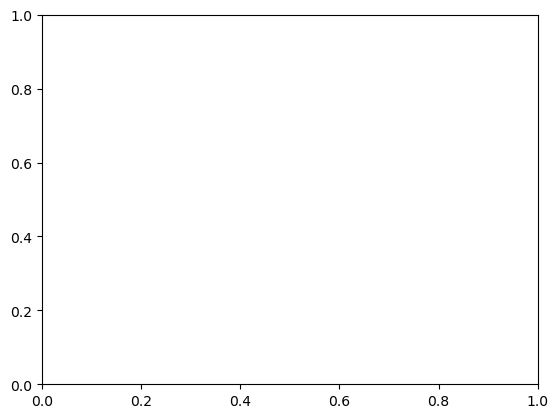

In [78]:
#using different colors based on labels
import matplotlib.pyplot as plt

# Sample data
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16 ,17 ,18 ,19 ,20]
y = results
labels = ['AI', 'AI', 'AI', 'AI', 'AI', 'AI','AI','AI','AI','AI', 'human','human','human','human','human','human','human','human','human','human','human']

# Define colors for different labels
#colors = {'human': 'red', 'AI': 'blue'}
colors = ['red' if value > 20 else 'green' for value in y]

# Create scatter plot
for i in range(len(x)):
    #plt.scatter(x[i], y[i], color=colors[labels[i]])
    plt.scatter(x[i], y[i], color=colors)

# Set labels and title
plt.xlabel('Sample no.')
plt.ylabel('Perplexity score')
plt.title('AI generated text (blue) vs Human written text (red)')
#plt.legend('red: human text, blue: AI text')
# Show the plot
plt.show()

In this notebook we've compared 10 AI generated texts with 10 texts written by humans and calculated their perplexity. When we plotted the results we see a difference between AI-generated texts (low perplexity) and human written text (high perplexity). 

Without doubt, more testing is needed, especially with other types of text, to get more reliable results.

## Testing with chunks of text

In [3]:
text2check ='Ik hoop dat deze e-mail u goed bereikt. Ik schrijf u met betrekking tot de deadline van vandaag voor Mini technische portfolio. Het spijt me ten zeerste dat ik niet in staat ben om het op tijd in te leveren. Ik begrijp dat tijdige indiening van het grootste belang is en ik bied mijn oprechte verontschuldigingen aan voor het niet nakomen van de deadline. De reden dat ik de opdracht niet op tijd kan voltooien, is omdat ik niet genoeg tijd had. Ik heb alles in het werk gesteld om het tijdig af te ronden, maar ik ben geconfronteerd met onverwachte omstandigheden die mijn voortgang hebben vertraagd. Ik betreur het dat ik niet eerder contact met u heb opgenomen om deze situatie te bespreken, maar ik hoop dat u begrip kunt opbrengen voor mijn situatie.Daarom wil ik graag vragen of het mogelijk is om een verlenging te krijgen en de opdracht uiterlijk aanstaande zondag in te leveren. Ik verzeker u dat ik er alles aan zal doen om de opdracht volledig en naar behoren af te ronden binnen de extra tijd die ik vraag. Ik begrijp dat dit afhankelijk is van uw goedkeuring en ik ben u zeer dankbaar als u mij deze kans wilt geven.Nogmaals, mijn oprechte excuses voor het niet nakomen van de deadline. Ik waardeer uw begrip en ik hoop dat we een oplossing kunnen vinden waarmee ik de opdracht als nog succesvol kan afronden.Ik kijk uit naar jullie reactie!'

In [43]:
#getting the perplexity tensor for the openai generated text
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

inputs_text = tokenizer(text2check, return_tensors = "pt")
loss = model(input_ids = inputs_text["input_ids"], labels = inputs_text["input_ids"]).loss
ppl = torch.exp(loss)
tensor_string=str(ppl)
a,b = tensor_string.split(",")
tensor, perplexity = a.split("(")
ppl = float(perplexity)
print(ppl)

115.0131


In [69]:
print(x)
print(y)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[67.5429, 58.108, 48.4369, 69.6907, 44.2813, 69.5256, 46.7678, 99.2462, 32.8285, 82.521, 211.6711, 222.4663, 304.6771, 326.6619, 327.4499, 305.0379, 141.3531, 360.3304, 153.0569, 207.1511]


In [70]:
x.append(21)
y.append(ppl)
print(x)
print(y)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
[67.5429, 58.108, 48.4369, 69.6907, 44.2813, 69.5256, 46.7678, 99.2462, 32.8285, 82.521, 211.6711, 222.4663, 304.6771, 326.6619, 327.4499, 305.0379, 141.3531, 360.3304, 153.0569, 207.1511, 115.0131]


In [72]:
print(len(y))

21


In [75]:
import matplotlib.pyplot as plt

def plot_scatter(x, y):
    # Define colors for different labels
    #colors = {'human': 'red', 'AI': 'blue'}
    colors = ['red' if value > 100 else 'green' for value in y]
    # Create scatter plot
    for i in range(len(x)):
        plt.scatter(x[i], y[i])

    # Set labels and title
    plt.xlabel('Sample no.')
    plt.ylabel('Perplexity score')
    plt.title('AI generated text (blue) vs Human written text (red)')

    # Show the plot
    plt.show()

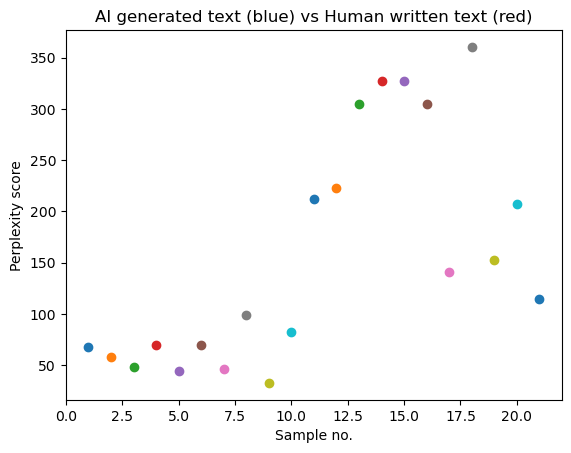

In [76]:
plot_scatter(x, y)